In [2]:
library( DESeq2 )
library( ggplot2 )
library( biomaRt )
library( gplots )
library( genefilter )



Attaching package: 'gplots'

The following object is masked from 'package:IRanges':

    space

The following object is masked from 'package:S4Vectors':

    space

The following object is masked from 'package:stats':

    lowess


Attaching package: 'genefilter'

The following objects are masked from 'package:matrixStats':

    rowSds, rowVars



estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


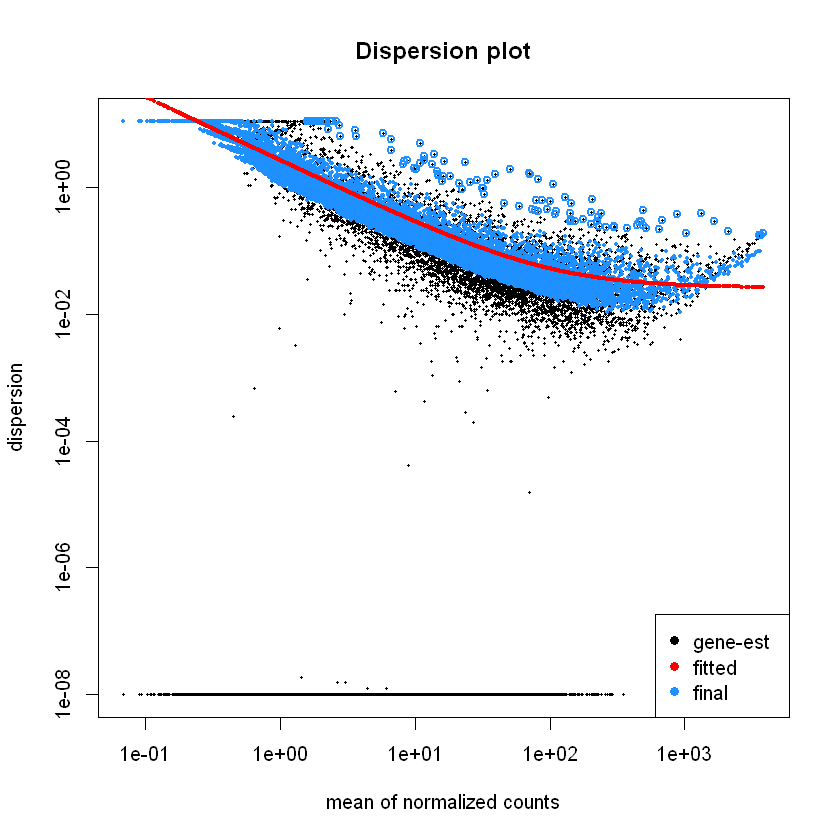

In [223]:
species.db <- "mmusculus_gene_ensembl"
db.version <- "grcm38"
metadata.file <- "sample_sheet_Patrick_AdiposeMacs.txt"
contrasts <- list( c( "series", "HFD-pLex", "HFD-SEA" ),
                 c( "HFD-worm", 1, 0))
fdr <- 0.05
lfc <- 0

# read in metadata
metadata <- read.csv("rmetadata.csv")
colnames(metadata) = c("id", "fname", "series")
metadata["HFD-worm"] = metadata["series"] %in% c("HFD-pLex", "HFD-SEA")
metadata["HFD-worm"] = metadata["HFD-worm"] - as.integer(metadata["series"] == "LFD")
# generate object for DESeq2
cds <- DESeqDataSetFromHTSeqCount( sampleTable = metadata,
                                   directory = "htseq_count",
                                   design = ~ series )
cds <- cds[ which( rowSums( counts( cds ) ) > 1 ), ]
counts <- counts( cds )

# NBM fit
dds <- DESeq( cds )
saveRDS( dds, file = "deseq2_fit.RDS" )
plotDispEsts( dds, main = "Dispersion plot" )

# create database for annotation before running loops
mart <- useMart( "ENSEMBL_MART_ENSEMBL", dataset = species.db ) 
# host = "www.biomart.org" )
# host = paste0( db.version, ".ensembl.org" ) )
filters <- c("external_gene_name")
attributes <- c("external_gene_name", "name_1006")

png 
  2

In [224]:
# maintain un-annotated genes in BioMart, otherwise it will just get excluded in annotation data frame 
# resulting in un-identified rows in the stats data frame

all.single_anno <- merge( all.genes, all.anno, by.x = "Ensembl", by.y = "external_gene_name",
                  all.x = T )
all.single_anno <- all.single_anno[ match( all.genes[,1], all.single_anno$Ensembl ), ] # reorder the annotation by LFC order

In [219]:
# resulting in un-identified rows in the stats data frame
all.anno.wStats <- data.frame( all.single_anno, all )
write.table( all.anno.wStats, paste0(currcon[2], "_vs_", currcon[3], "_FDR", fdr, "_ALL.txt" ),
           sep="\t", quote=F, row.names=F, col.names=T )
write.table( all.anno.wStats[,2], paste0(currcon[2], "_vs_", currcon[3], "_FDR", fdr, "_ALL_GeneList.txt" ),
           sep="\t", quote=F, row.names=F, col.names=F )

# Upregulated genes only
up.anno.wStats <- subset(all.anno.wStats, padj < fdr & log2FoldChange > lfc )
up.anno.wStats <- up.anno.wStats[ order( up.anno.wStats$log2FoldChange, decreasing = T ), ]

write.table( up.anno.wStats, paste0(currcon[2], "_vs_", currcon[3], "_FDR", fdr, "_up.txt" ),
           sep="\t", quote=F, row.names=F, col.names=T )
write.table( up.anno.wStats[,2], paste0(currcon[2], "_vs_", currcon[3], "_FDR", fdr, "_up_GeneList.txt" ),
           sep="\t", quote=F, row.names=F, col.names=F )

# Downregulated genes only
down.anno.wStats <- subset(all.anno.wStats, padj < fdr & log2FoldChange < lfc )
down.anno.wStats <- down.anno.wStats[ order( down.anno.wStats$log2FoldChange, decreasing = F ), ]

write.table( down.anno.wStats, paste0(currcon[2], "_vs_", currcon[3], "_FDR", fdr, "_down.txt" ),
           sep="\t", quote=F, row.names=F, col.names=T )
write.table( down.anno.wStats[,2], paste0(currcon[2], "_vs_", currcon[3], "_FDR", fdr, "_down_GeneList.txt" ),
           sep="\t", quote=F, row.names=F, col.names=F )


In [111]:
for (fac in 1:length(contrasts)) {
  currcon <- contrasts[[fac]]
  res <- results( dds, contrast = currcon )
  
  pdf( paste0( currcon[2], "_vs_", currcon[3], ".pdf" ) )
  DESeq2::plotMA( res, main = paste0( currcon[2], " vs ", currcon[3] ),
                  ylim = c( -5, 5 ), alpha = fdr )
  dev.off()
  
  # All differential genes
  all <- subset( res, padj < fdr )
  all <- all[ order( all$log2FoldChange, decreasing = T ), ]
  # all annotation
  all.genes <- rownames( all ) # rownames = ensembl gene ids
  all.genes <- data.frame( all.genes )
  colnames( all.genes )[1] <- "Ensembl"
  rows = all.genes[,1]
  all.anno <- getBM( attributes = attributes, filters = filters, 
                     values = list("external_gene_name" = rows, "mgi_symbol"=rows),
                     mart = mart) # get all annotation based on ensembl ids
  # maintain un-annotated genes in BioMart, otherwise it will just get excluded in annotation data frame 
  # resulting in un-identified rows in the stats data frame
  all.anno2 <- merge( all.genes, all.anno, by.x = "Ensembl", by.y = "ensembl_gene_id",
                      all.x = T )
  all.anno2 <- all.anno2[ match( all.genes[,1], all.anno2$Ensembl ), ] # reorder the annotation by LFC order
  all.anno.wStats <- data.frame( all.anno2, all )
  write.table( all.anno.wStats, paste0(currcon[2], "_vs_", currcon[3], "_FDR", fdr, "_ALL.txt" ),
               sep="\t", quote=F, row.names=F, col.names=T )
  write.table( all.anno.wStats[,2], paste0(currcon[2], "_vs_", currcon[3], "_FDR", fdr, "_ALL_GeneList.txt" ),
               sep="\t", quote=F, row.names=F, col.names=F )
  
  # Upregulated genes only
  up.anno.wStats <- subset(all.anno.wStats, padj < fdr & log2FoldChange > lfc )
  up.anno.wStats <- up.anno.wStats[ order( up.anno.wStats$log2FoldChange, decreasing = T ), ]
  
  write.table( up.anno.wStats, paste0(currcon[2], "_vs_", currcon[3], "_FDR", fdr, "_up.txt" ),
               sep="\t", quote=F, row.names=F, col.names=T )
  write.table( up.anno.wStats[,2], paste0(currcon[2], "_vs_", currcon[3], "_FDR", fdr, "_up_GeneList.txt" ),
               sep="\t", quote=F, row.names=F, col.names=F )
  
  # Downregulated genes only
  down.anno.wStats <- subset(all.anno.wStats, padj < fdr & log2FoldChange < lfc )
  down.anno.wStats <- down.anno.wStats[ order( down.anno.wStats$log2FoldChange, decreasing = F ), ]
  
  write.table( down.anno.wStats, paste0(currcon[2], "_vs_", currcon[3], "_FDR", fdr, "_down.txt" ),
               sep="\t", quote=F, row.names=F, col.names=T )
  write.table( down.anno.wStats[,2], paste0(currcon[2], "_vs_", currcon[3], "_FDR", fdr, "_down_GeneList.txt" ),
               sep="\t", quote=F, row.names=F, col.names=F )
  
}


ERROR: Error in fix.by(by.y, y): 'by' must specify a uniquely valid column


### Regularized transformation of read counts.
Take only genes with a max value >25th percentile of the per-gene max value.


In [221]:
rld <- rlog( cds, blind = T )
rld <- assay( rld )
maxPerGene <- apply( rld, 1, max )
rld.25p <- rld[ which( maxPerGene > quantile( maxPerGene )[2] ), ]
